# ●データ拡張
学習データが少ないと過学習が発生し、汎化性能が低下してしまいます。  
しかしながら、多くの画像などの学習データを集めるのには大きな手間がかかります。  
この問題への対策の一つが**データ拡張**です。  
データ拡張は、画像に反転、拡大、縮小などの変換を加えることで、学習データの「水増し」を行います。  
これにより、学習データ不足の問題が解消されることがあります。

## ●データ拡張の実装
KerasのImageDataGeneratorを使ってデータ拡張を行います。  
今回は、cifar-10の画像に回転を加えたものをいくつか生成します。  
画像を表示するコードは、再利用のため関数にまとめておきます。  

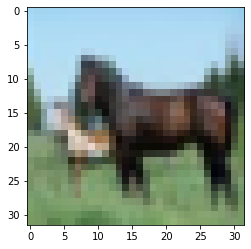

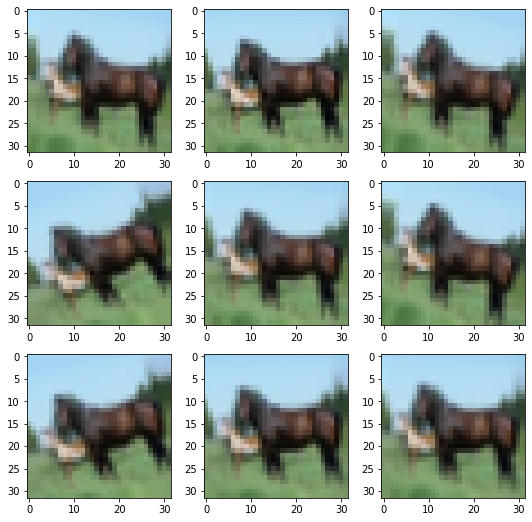

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

(x_train, t_train), (x_test, t_test) = cifar10.load_data()

image = x_train[12]
plt.imshow(image)
plt.show()

def show_images(image, generator):
    channel, height, width = image.shape
    image = image.reshape(1, channel, height, width)  # バッチ対応
    gen = generator.flow(image, batch_size=1)  # 変換された画像の生成

    plt.figure(figsize=(9, 9))
    for i in range(9):
        gen_img = gen.next()[0].astype(np.uint8)  # 画像の取得
        plt.subplot(3, 3, i + 1)
        plt.imshow(gen_img)
    plt.show()

# -20°から20°の範囲でランダムに回転を行う画像生成器
generator = ImageDataGenerator(rotation_range=20)
show_images(image, generator)

## ●様々なデータ拡張
width_shift_rangeを指定することにより、画像を水平方向にシフトすることができます。

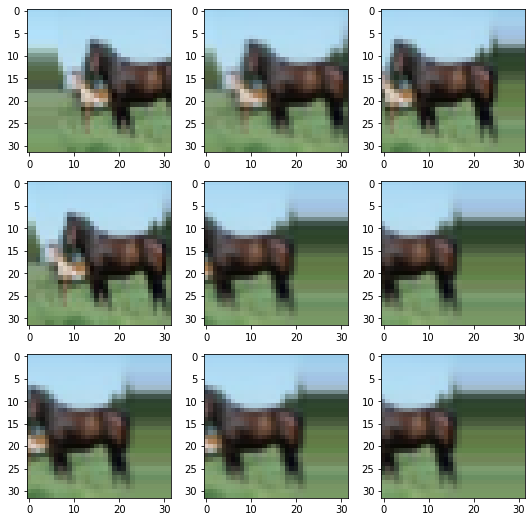

In [2]:
generator = ImageDataGenerator(width_shift_range=0.5)  # 画像サイズの半分の範囲でランダムにシフトする
show_images(image, generator)

height_shift_rangeを指定することにより、画像を垂直方向にシフトすることができます。

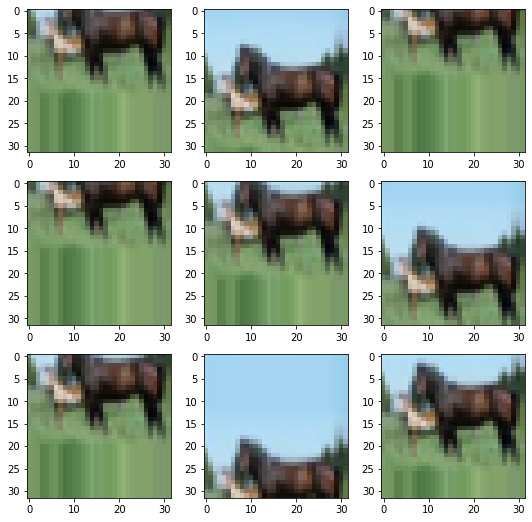

In [3]:
generator = ImageDataGenerator(height_shift_range=0.5)  # 画像サイズの半分の範囲でランダムにシフトする
show_images(image, generator)

shear_rangeによりシアー強度の範囲を指定すると、引っ張るような変換を加えた画像を生成することができます。

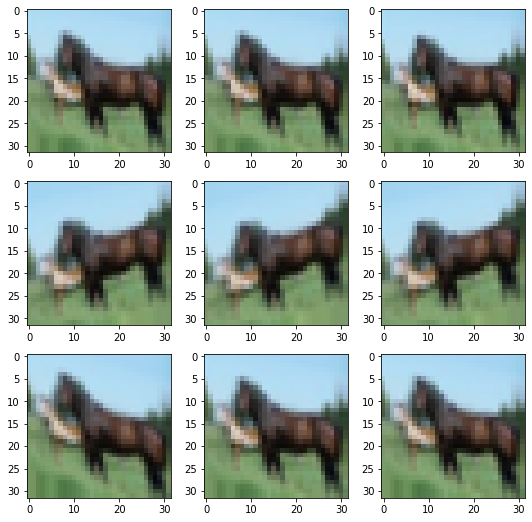

In [4]:
generator = ImageDataGenerator(shear_range=20)  # シアー強度の範囲を指定
show_images(image, generator)

zoom_rangeで拡大縮小する範囲を指定することができます。  
この範囲内で、水平方向、垂直方向それぞれの拡大率がランダムに指定されます。

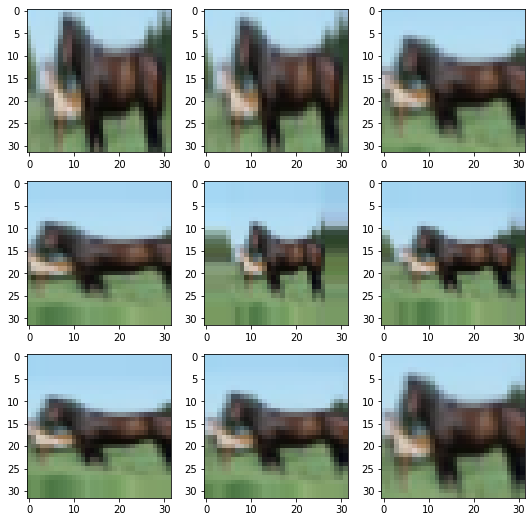

In [5]:
generator = ImageDataGenerator(zoom_range=0.4)  # 拡大縮小する範囲を指定
show_images(image, generator)

horizontal_flipとvertical_flipで、水平及び垂直方向に反転することができます。

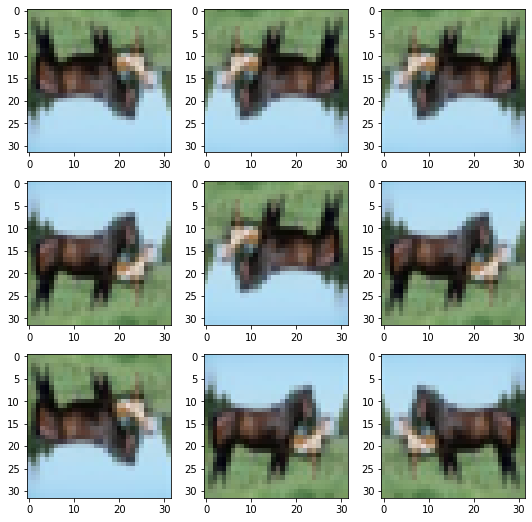

In [6]:
generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)  # 水平、垂直方向にランダムに反転
show_images(image, generator)

## ●CNNへの適用
CNNの入力をデータ拡張します。  
使用するモデルは、以前に構築したものと同じです。

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils

batch_size = 32
epochs = 20
n_class = 10

t_train = np_utils.to_categorical(t_train, n_class)  # one-hot表現に
t_test = np_utils.to_categorical(t_test, n_class)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))  # ゼロパディング、バッチサイズ以外の画像の形状を指定
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # 一次元の配列に変換
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))  # ドロップアウト
model.add(Dense(n_class))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 15, 15, 64)       

## ●学習
モデルを訓練します。  
ImageDataGeneratorを使用する際は、学習にfit_generatorメソッドを使います。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

In [15]:
x_train = x_train / 255  # 0から1の範囲に収める
x_test = x_test / 255

generator = ImageDataGenerator(
           rotation_range=0.2,
           horizontal_flip=True)
generator.fit(x_train)

history = model.fit_generator(generator.flow(x_train, t_train, batch_size=batch_size),
                              epochs=epochs,
                              validation_data=(x_test, t_test))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1563/1563 [==============================] - 30s 19ms/step - loss: 1.7401 - accuracy: 0.3517 - val_loss: 1.1778 - val_accuracy: 0.5745
Epoch 2/20
1563/1563 [==============================] - 27s 18ms/step - loss: 1.1801 - accuracy: 0.5790 - val_loss: 0.9480 - val_accuracy: 0.6626
Epoch 3/20
1563/1563 [==============================] - 29s 19ms/step - loss: 0.9898 - accuracy: 0.6517 - val_loss: 0.9203 - val_accuracy: 0.6721
Epoch 4/20
1563/1563 [==============================] - 27s 18ms/step - loss: 0.8757 - accuracy: 0.6928 - val_loss: 0.8342 - val_accuracy: 0.7116
Epoch 5/20
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8085 - accuracy: 0.7190 - val_loss: 0.7546 - val_accuracy: 0.7413
Epoch 6/20
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7486 - accuracy: 0.7391 - val_loss: 0.7560 - val_accuracy: 0.7443
Epoch 7/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.7241 - accuracy: 0.7450 - val_loss: 0.7165 -

## ●学習の推移
学習の推移を表示します。  
データ拡張をしていない場合と比較して、汎化性能が向上していることを確認しましょう。

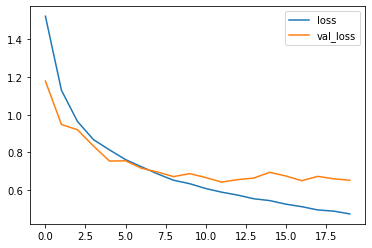

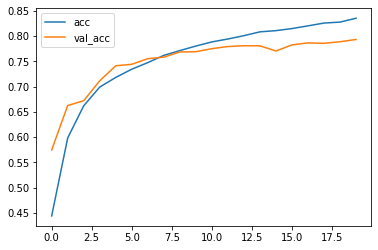

In [17]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']  # 訓練用データの誤差
train_acc = history.history['accuracy']  # 訓練用データの精度
val_loss = history.history['val_loss']  # 検証用データの誤差
val_acc = history.history['val_accuracy']  # 検証用データの精度

plt.plot(np.arange(len(train_loss)), train_loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label='acc')
plt.plot(np.arange(len(val_acc)), val_acc, label='val_acc')
plt.legend()
plt.show()

## ●評価
モデルの評価を行います。  

In [18]:
loss, accuracy = model.evaluate(x_test, t_test)
print(loss, accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.6528 - accuracy: 0.7934
0.6528123021125793 0.79339998960495
